In [1]:
from deap import base
from deap import creator
from deap import tools
from deap import algorithms

In [5]:
from _volume_rate_of_change import VolumeRateOfChange

In [6]:
import random
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

In [7]:
data=pd.read_csv("MASI_2.csv",parse_dates=True, index_col=0)

In [8]:
data["Volume"]=data["Close"]

In [9]:
data

,Open,High,Low,Close,Volume,Currency
Date,,,,,,
2002-01-03,3684.51,3694.96,3640.00,3640.00,3640.00,MAD
2002-01-04,3641.08,3671.50,3640.00,3671.50,3671.50,MAD
2002-01-07,3670.56,3674.71,3662.56,3667.30,3667.30,MAD
2002-01-08,3655.56,3657.54,3639.32,3641.65,3641.65,MAD
2002-01-09,3637.89,3645.03,3627.77,3644.19,3644.19,MAD
...,...,...,...,...,...,...
2022-05-16,12682.21,12738.15,12648.59,12682.77,12682.77,MAD
2022-05-17,12682.77,12733.07,12681.66,12716.65,12716.65,MAD
2022-05-18,12716.65,12749.42,12672.62,12679.96,12679.96,MAD


In [10]:
df=data["Close"].loc["2002-01-01":]
high=data["High"].loc["2002-01-01":]
low=data["Low"].loc["2002-01-01":]

## Fonction

In [11]:
premier=0 

In [12]:
def GeneticAlgo(dim,obj_func,MAX_GENERATIONS,BOUND_LOW,BOUND_UP,POPULATION_SIZE=40,P_CROSSOVER = 0.9,P_MUTATION = 0.1):
	global premier
	ONE_MAX_LENGTH=dim
	HALL_OF_FAME_SIZE = 5
	CROWDING_FACTOR=20
	RANDOM_SEED = 40
	random.seed(RANDOM_SEED)
	if premier> 0 :
		del creator.FitnessMax
		del creator.Individual
	premier=premier+1
	toolbox = base.Toolbox()
	toolbox.register("Num", random.randint, BOUND_LOW, BOUND_UP)
	creator.create("FitnessMax", base.Fitness, weights=(1.0,))
	creator.create("Individual", list, fitness=creator.FitnessMax)
	toolbox.register("individualCreator", tools.initRepeat, creator.Individual, toolbox.Num, ONE_MAX_LENGTH)
	toolbox.register("populationCreator", tools.initRepeat, list, toolbox.individualCreator)
	toolbox.register("evaluate", obj_func)
	toolbox.register("select", tools.selTournament, tournsize=3)
	toolbox.register("mate", tools.cxSimulatedBinaryBounded, low=BOUND_LOW, up=BOUND_UP, eta=CROWDING_FACTOR)
	toolbox.register("mutate", tools.mutPolynomialBounded, low=BOUND_LOW, up=BOUND_UP, eta=CROWDING_FACTOR, indpb=0.20)
	def main():
		population = toolbox.populationCreator(n=POPULATION_SIZE)
		stats = tools.Statistics(lambda ind: ind.fitness.values)
		stats.register("max", np.max)
		stats.register("avg", np.mean)
		hof = tools.HallOfFame(HALL_OF_FAME_SIZE)
		population, logbook = algorithms.eaSimple(population, toolbox, cxpb=P_CROSSOVER, mutpb=P_MUTATION,ngen=MAX_GENERATIONS
			, stats=stats, halloffame=hof, verbose=True)
		print("Hall of Fame Individuals = ", *hof.items, sep="\n")
		print("Best Ever Individual = ", [ int(i) for i in hof.items[0]])
		maxFitnessValues, meanFitnessValues = logbook.select("max", "avg")
		sns.set_style("whitegrid")
		plt.plot(maxFitnessValues, color='red')
		plt.plot(meanFitnessValues, color='green')
		plt.xlabel('Génération')
		plt.ylabel('Max / Moyenne Fitness')
		plt.title('Max et Moyenne de  Fitness par générations')
		plt.show()
	main()

In [13]:
# Coût des transactions
ti=0.0022
fr=0.0011
cb=0.0011
taux=ti+fr+cb

In [17]:
ROC=VolumeRateOfChange(data)

In [23]:
ROC.getTiData()

,vrc
Date,
2002-01-03,NaN
2002-01-04,NaN
2002-01-07,NaN
2002-01-08,NaN
2002-01-09,NaN
...,...
2022-05-16,-3.994777
2022-05-17,-4.024993
2022-05-18,-4.247483


<module 'matplotlib.pyplot' from 'C:\\Users\\pc\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

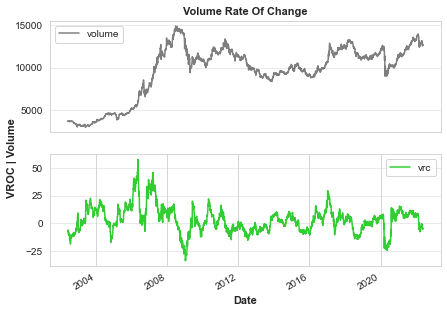

In [24]:
ROC.getTiGraph()

In [18]:
def pmv(close,signal):
	"""
		La Plus-ou-moins-value
	"""
	close=np.array(close)
	signal=np.array(signal.fillna(0))
	qt=signal.cumsum()
	achat= np.where(signal>=1,1,0)
	PDR=[]
	for t in range(len(close)):
		p=(close[:t+1]*achat[:t+1]).sum()
		if achat[:t+1].sum()==0 :
			val=0
		else :
			p=p/(achat[:t+1].sum())
			val=qt[t]*p 
		PDR.append(val)
	PMV_lat=close*qt-PDR
	PMV_re=[0]
	for i in range(1,len(close)):
		vl=PDR[i]-PDR[i-1]+PMV_re[i-1]-close[i]*signal[i]
		PMV_re.append(vl)
	PMV=PMV_lat+PMV_re
	return PMV

In [19]:
def adjustsignal(signal):
	sig=[]
	qtite=0
	for i in signal:
		if i > 0 :
			sig.append(i)
			qtite+=1
		elif i < 0:
			if qtite >= abs(i) :
				sig.append(i)
				qtite+=-i
			else:
				sig.append(0)
		else:
			sig.append(0)
	return sig

In [20]:
def obj_roc(n):
    period=int(n[0])
    signal=pd.DataFrame(index=df.index)
    roc=ROC._calculateTi(period)["vrc"]
    #roc=at.rate_of_change(df,w)["ROC"]
    signal["compa"]=np.nan
    signal["compa"][period:]=np.where( roc[period:]> 0,1,0)
    signal["signal"]=adjustsignal(signal["compa"].diff())
    cours=df*(1+taux*signal["signal"])
    pmval=pmv(cours,signal["signal"])
    return pmval.max(),

gen	nevals	max    	avg   
0  	40    	9672.41	8622.2
1  	36    	9672.41	8990.87
2  	36    	10009.5	9430   
3  	38    	10009.5	9635.65
4  	40    	10009.5	9675.58
5  	36    	10009.5	9791.21
6  	35    	10009.5	9896.9 
7  	34    	10009.5	10001.1
8  	38    	10009.5	9979.74
9  	36    	10009.5	10009.5
10 	32    	10009.5	10009.5
Hall of Fame Individuals = 
[12.942832015325724]
[12.970376305197457]
[12.566396226818089]
[12.565117527242009]
[12.960617592581624]
Best Ever Individual =  [12]


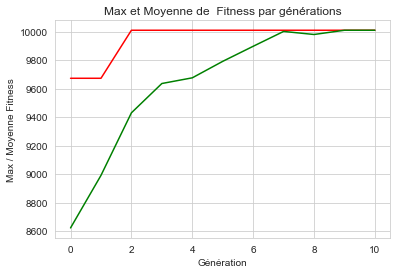

In [22]:
GeneticAlgo(1,obj_roc,10,10,30)